In [1]:
import scanpy as sc

# import mudata as mu
from pathlib import Path
import pandas as pd

%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import squidpy as sq
import pathlib

path = pathlib.Path("/lustre/groups/ml01/workspace/moscot_paper/mapping")
ad_viz = sq.read.vizgen(
    path=path,
    counts_file="Liver1Slice1_cell_by_gene.csv",
    meta_file="Liver1Slice1_cell_metadata.csv",
)

In [3]:
sc.pp.filter_cells(ad_viz, min_counts=50)
sc.pp.filter_genes(ad_viz, min_cells=5)

In [4]:
ad_viz

AnnData object with n_obs × n_vars = 367235 × 347
    obs: 'fov', 'volume', 'min_x', 'max_x', 'min_y', 'max_y', 'n_counts'
    var: 'n_cells'
    uns: 'spatial'
    obsm: 'blank_genes', 'spatial'

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


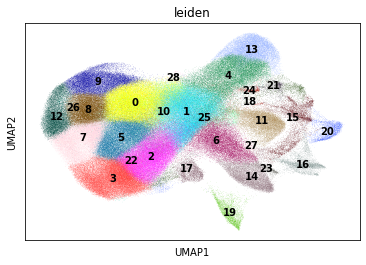

In [5]:
# dividing by volume instead
ad_viz.layers["counts"] = ad_viz.X.copy()
resolution = 1.5
# Leiden Clustering
######################

# dividing by volume instead
sc.pp.normalize_total(ad_viz)
sc.pp.log1p(ad_viz)
ad_viz.layers["normalized"] = ad_viz.X.copy()
sc.pp.scale(ad_viz, max_value=10)
sc.tl.pca(ad_viz, svd_solver="arpack")
sc.pp.neighbors(ad_viz, n_neighbors=10, n_pcs=20)
# sc.pp.neighbors(ad_viz)
sc.tl.umap(ad_viz)
sc.tl.leiden(ad_viz, resolution=resolution)

# Calculate Leiden Signatures
#########################################
ser_counts = ad_viz.obs["leiden"].value_counts()
ser_counts.name = "cell counts"
meta_leiden = pd.DataFrame(ser_counts)

cat_name = "leiden"
sig_leiden = pd.DataFrame(
    columns=ad_viz.var_names, index=ad_viz.obs[cat_name].cat.categories
)
for clust in ad_viz.obs[cat_name].cat.categories:
    sig_leiden.loc[clust] = ad_viz[ad_viz.obs[cat_name].isin([clust]), :].X.mean(0)
sig_leiden = sig_leiden.transpose()
leiden_clusters = ["Leiden-" + str(x) for x in sig_leiden.columns.tolist()]
sig_leiden.columns = leiden_clusters
meta_leiden.index = sig_leiden.columns.tolist()
meta_leiden["leiden"] = pd.Series(
    meta_leiden.index.tolist(), index=meta_leiden.index.tolist()
)

# generate colors for categories by plotting
sc.pl.umap(ad_viz, color="leiden", legend_loc="on data")
cats = ad_viz.obs["leiden"].cat.categories.tolist()
colors = list(ad_viz.uns["leiden_colors"])
cat_colors = dict(zip(cats, colors))

In [7]:
import numpy as np
from copy import deepcopy

gene_panel = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41421-021-00266-1/MediaObjects/41421_2021_266_MOESM1_ESM.xlsx"

df_ref_panel_ini = pd.read_excel(gene_panel, index_col=0)
df_ref_panel = df_ref_panel_ini.iloc[1:, :1]
df_ref_panel.index.name = None
df_ref_panel.columns = ["Function"]

# Assign marker gene metadata using reference dataset
marker_genes = df_ref_panel[
    df_ref_panel["Function"].str.contains("marker")
].index.tolist()

meta_gene = deepcopy(ad_viz.var)
common_marker_genes = list(set(meta_gene.index.tolist()).intersection(marker_genes))
meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[
    common_marker_genes, "Function"
]
meta_gene["Markers"] = meta_gene["Markers"].apply(
    lambda x: "N.A." if "marker" not in str(x) else x
)
meta_gene["Markers"].value_counts()

N.A.                            285
HSC marker                        8
Hepatocyte marker                 5
Erythroid progenitor marker       5
Macrophage marker                 5
SEC marker                        5
Neutrophil marker                 5
MK marker                         5
Potential HSC marker              5
Pre-B cell marker                 5
Erythroid cell marker             4
EC marker                         4
AEC marker                        2
Myeloid marker                    2
Macrophage/Hepatocyte marker      1
Basophil marker                   1
Name: Markers, dtype: int64

In [8]:
ser_counts = ad_viz.obs["leiden"].value_counts()
ser_counts.name = "cell counts"
meta_leiden = pd.DataFrame(ser_counts)

cat_name = "leiden"
sig_leiden = pd.DataFrame(
    columns=ad_viz.var_names, index=ad_viz.obs[cat_name].cat.categories
)
for clust in ad_viz.obs[cat_name].cat.categories:
    sig_leiden.loc[clust] = ad_viz[ad_viz.obs[cat_name].isin([clust]), :].X.mean(0)
sig_leiden = sig_leiden.transpose()
leiden_clusters = ["Leiden-" + str(x) for x in sig_leiden.columns.tolist()]
sig_leiden.columns = leiden_clusters
meta_leiden.index = sig_leiden.columns.tolist()
meta_leiden["leiden"] = pd.Series(
    meta_leiden.index.tolist(), index=meta_leiden.index.tolist()
)

In [9]:
meta_gene = pd.DataFrame(index=sig_leiden.index.tolist())
meta_gene["info"] = pd.Series("", index=meta_gene.index.tolist())
meta_gene["Markers"] = pd.Series("N.A.", index=sig_leiden.index.tolist())
meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[
    common_marker_genes, "Function"
]

meta_leiden["Cell_Type"] = pd.Series("N.A.", index=meta_leiden.index.tolist())
num_top_genes = 30
for inst_cluster in sig_leiden.columns.tolist():
    top_genes = (
        sig_leiden[inst_cluster]
        .sort_values(ascending=False)
        .index.tolist()[:num_top_genes]
    )

    inst_ser = meta_gene.loc[top_genes, "Markers"]
    inst_ser = inst_ser[inst_ser != "N.A."]
    ser_counts = inst_ser.value_counts()

    max_count = ser_counts.max()

    max_cat = "_".join(sorted(ser_counts[ser_counts == max_count].index.tolist()))
    max_cat = max_cat.replace(" marker", "").replace(" ", "-")

    print(inst_cluster, max_cat)
    meta_leiden.loc[inst_cluster, "Cell_Type"] = max_cat

# rename clusters
meta_leiden["name"] = meta_leiden.apply(
    lambda x: x["Cell_Type"] + "_" + x["leiden"], axis=1
)
leiden_names = meta_leiden["name"].values.tolist()
meta_leiden.index = leiden_names


# transfer cell type labels to single cells
leiden_to_cell_type = deepcopy(meta_leiden)
leiden_to_cell_type.set_index("leiden", inplace=True)
leiden_to_cell_type.index.name = None

ad_viz.obs["Cell_Type"] = ad_viz.obs["leiden"].apply(
    lambda x: leiden_to_cell_type.loc["Leiden-" + str(x), "Cell_Type"]
)
ad_viz.obs["Cluster"] = ad_viz.obs["leiden"].apply(
    lambda x: leiden_to_cell_type.loc["Leiden-" + str(x), "name"]
)

Leiden-0 Hepatocyte
Leiden-1 SEC
Leiden-2 Hepatocyte
Leiden-3 Hepatocyte
Leiden-4 SEC
Leiden-5 Hepatocyte
Leiden-6 Macrophage
Leiden-7 Hepatocyte
Leiden-8 Hepatocyte
Leiden-9 Hepatocyte
Leiden-10 AEC_Hepatocyte
Leiden-11 AEC_Potential-HSC
Leiden-12 Hepatocyte
Leiden-13 SEC
Leiden-14 Macrophage
Leiden-15 MK
Leiden-16 HSC
Leiden-17 Neutrophil
Leiden-18 EC_MK_Pre-B-cell_SEC
Leiden-19 HSC_Pre-B-cell
Leiden-20 Neutrophil
Leiden-21 MK_Pre-B-cell_SEC
Leiden-22 Hepatocyte
Leiden-23 Macrophage
Leiden-24 SEC
Leiden-25 Erythroid-cell_MK
Leiden-26 Pre-B-cell
Leiden-27 Macrophage
Leiden-28 SEC


In [10]:
meta_leiden

cell counts     leiden             Cell_Type  \
Hepatocyte_Leiden-0                   37742   Leiden-0            Hepatocyte   
SEC_Leiden-1                          37481   Leiden-1                   SEC   
Hepatocyte_Leiden-2                   36038   Leiden-2            Hepatocyte   
Hepatocyte_Leiden-3                   35250   Leiden-3            Hepatocyte   
SEC_Leiden-4                          22210   Leiden-4                   SEC   
Hepatocyte_Leiden-5                   21201   Leiden-5            Hepatocyte   
Macrophage_Leiden-6                   20709   Leiden-6            Macrophage   
Hepatocyte_Leiden-7                   20673   Leiden-7            Hepatocyte   
Hepatocyte_Leiden-8                   18480   Leiden-8            Hepatocyte   
Hepatocyte_Leiden-9                   16518   Leiden-9            Hepatocyte   
AEC_Hepatocyte_Leiden-10              15679  Leiden-10        AEC_Hepatocyte   
AEC_Potential-HSC_Leiden-11           14362  Leiden-11     AEC_Potential-HSC   
Hepatocyte_Leiden-12                  13458  Leiden-12            Hepatocyte   
SEC_Leiden-13                         13344  Leiden-13                   SEC   
Macrophage_Leiden-14                  11581  Leiden-14            Macrophage   
MK_Leiden-15                           6777  Leiden-15                    MK   
HSC_Leiden-16                          4931  Leiden-16                   HSC   
Neutrophil_Leiden-17                   4196  Leiden-17            Neutrophil   
EC_MK_Pre-B-cell_SEC_Leiden-18         3714  Leiden-18  EC_MK_Pre-B-cell_SEC   
HSC_Pre-B-cell_Leiden-19               3447  Leiden-19        HSC_Pre-B-cell   
Neutrophil_Leiden-20                   3316  Leiden-20            Neutrophil   
MK_Pre-B-cell_SEC_Leiden-21            1563  Leiden-21     MK_Pre-B-cell_SEC   
Hepatocyte_Leiden-22                   1282  Leiden-22            Hepatocyte   
Macrophage_Leiden-23                   1059  Leiden-23            Macrophage   
SEC_Leiden-24                          1033  Leiden-24                   SEC   
Erythroid-cell_MK_Leiden-25             507  Leiden-25     Erythroid-cell_MK   
Pre-B-cell_Leiden-26                    312  Leiden-26            Pre-B-cell   
Macrophage_Leiden-27                    205  Leiden-27            Macrophage   
SEC_Leiden-28                           167  Leiden-28                   SEC   

                                                          name  
Hepatocyte_Leiden-0                        Hepatocyte_Leiden-0  
SEC_Leiden-1                                      SEC_Leiden-1  
Hepatocyte_Leiden-2                        Hepatocyte_Leiden-2  
Hepatocyte_Leiden-3                        Hepatocyte_Leiden-3  
SEC_Leiden-4                                      SEC_Leiden-4  
Hepatocyte_Leiden-5                        Hepatocyte_Leiden-5  
Macrophage_Leiden-6                        Macrophage_Leiden-6  
Hepatocyte_Leiden-7                        Hepatocyte_Leiden-7  
Hepatocyte_Leiden-8                        Hepatocyte_Leiden-8  
Hepatocyte_Leiden-9                        Hepatocyte_Leiden-9  
AEC_Hepatocyte_Leiden-10              AEC_Hepatocyte_Leiden-10  
AEC_Potential-HSC_Leiden-11        AEC_Potential-HSC_Leiden-11  
Hepatocyte_Leiden-12                      Hepatocyte_Leiden-12  
SEC_Leiden-13                                    SEC_Leiden-13  
Macrophage_Leiden-14                      Macrophage_Leiden-14  
MK_Leiden-15                                      MK_Leiden-15  
HSC_Leiden-16                                    HSC_Leiden-16  
Neutrophil_Leiden-17                      Neutrophil_Leiden-17  
EC_MK_Pre-B-cell_SEC_Leiden-18  EC_MK_Pre-B-cell_SEC_Leiden-18  
HSC_Pre-B-cell_Leiden-19              HSC_Pre-B-cell_Leiden-19  
Neutrophil_Leiden-20                      Neutrophil_Leiden-20  
MK_Pre-B-cell_SEC_Leiden-21        MK_Pre-B-cell_SEC_Leiden-21  
Hepatocyte_Leiden-22                      Hepatocyte_Leiden-22  
Macrophage_Leiden-23                      Macrophage_Leiden-23  
SEC_Le

/home/icb/giovanni.palla/miniconda3/envs/moscot/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


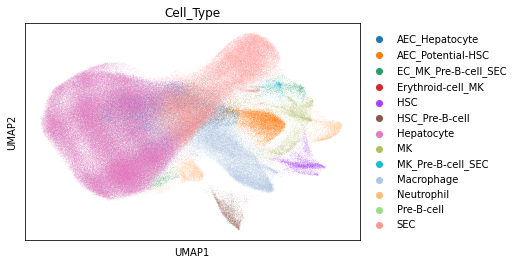

In [11]:
sc.pl.umap(ad_viz, color="Cell_Type")

/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


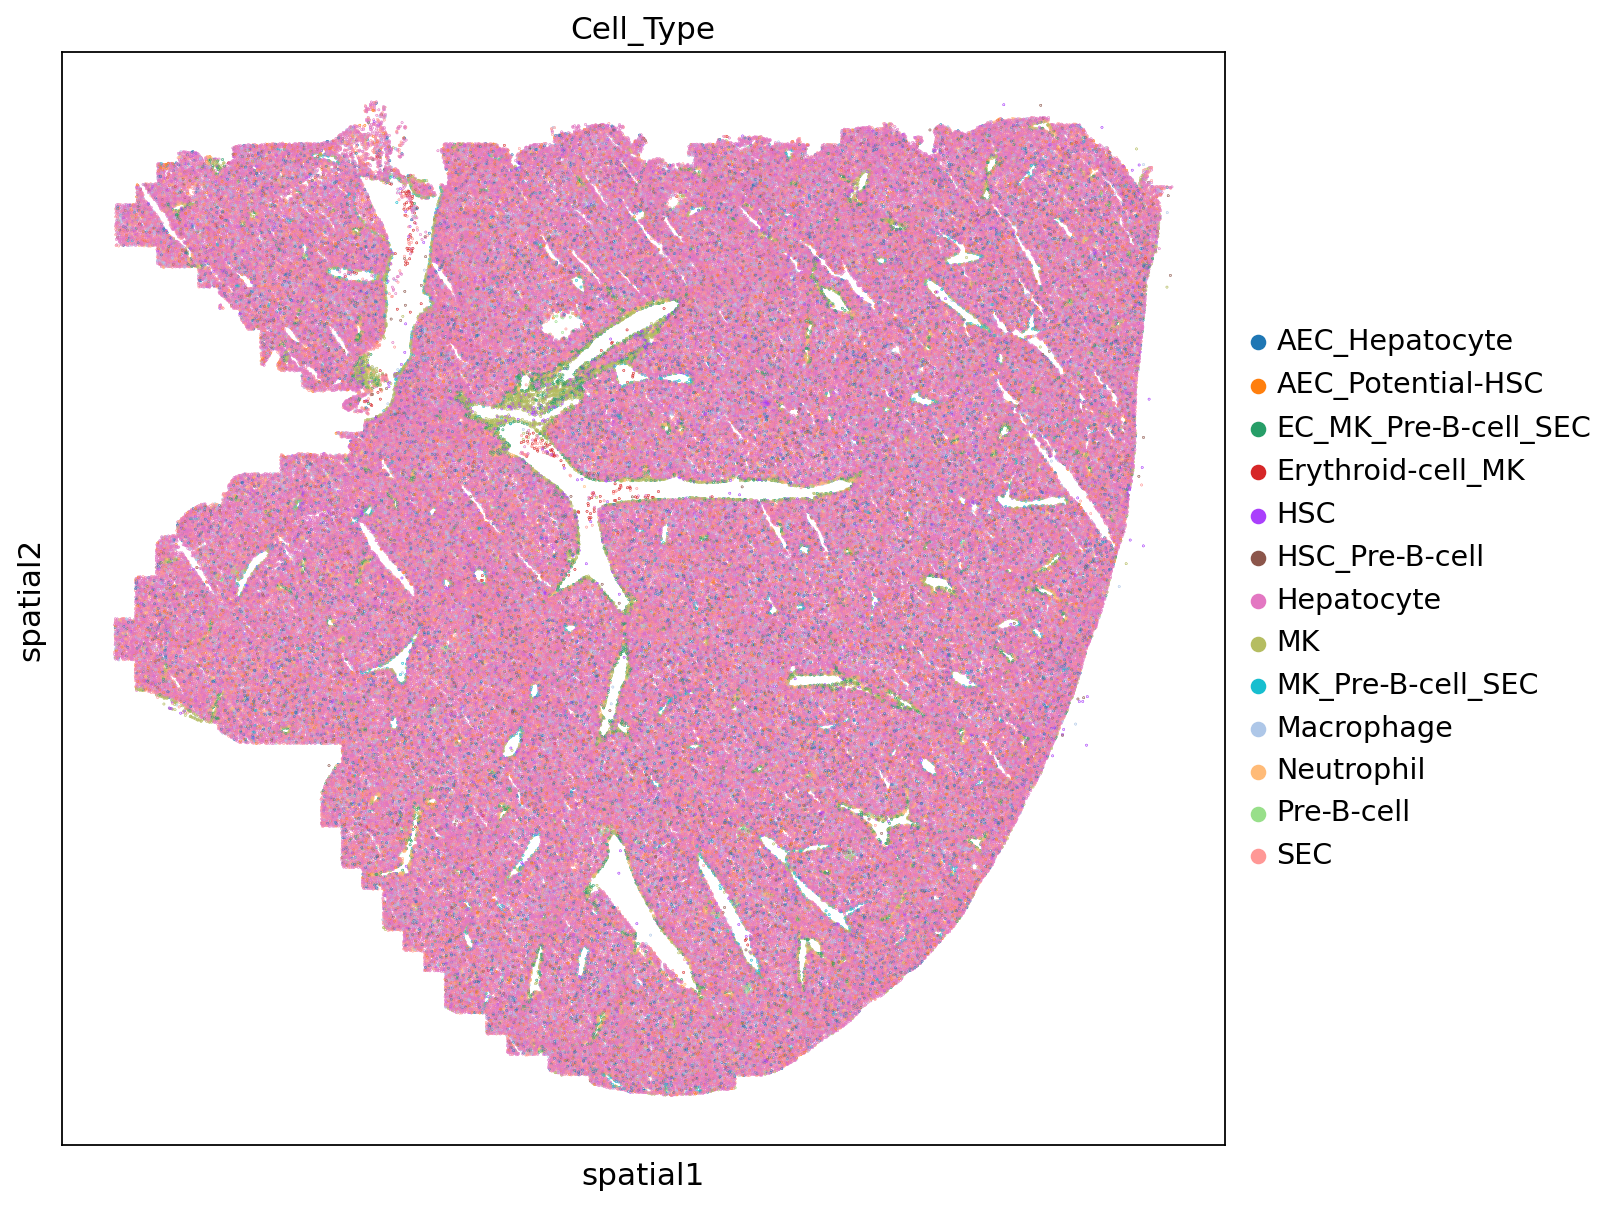

In [12]:
sc.set_figure_params(figsize=(10, 10))
sq.pl.spatial_scatter(ad_viz, shape=None, color="Cell_Type", size=0.1)

/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


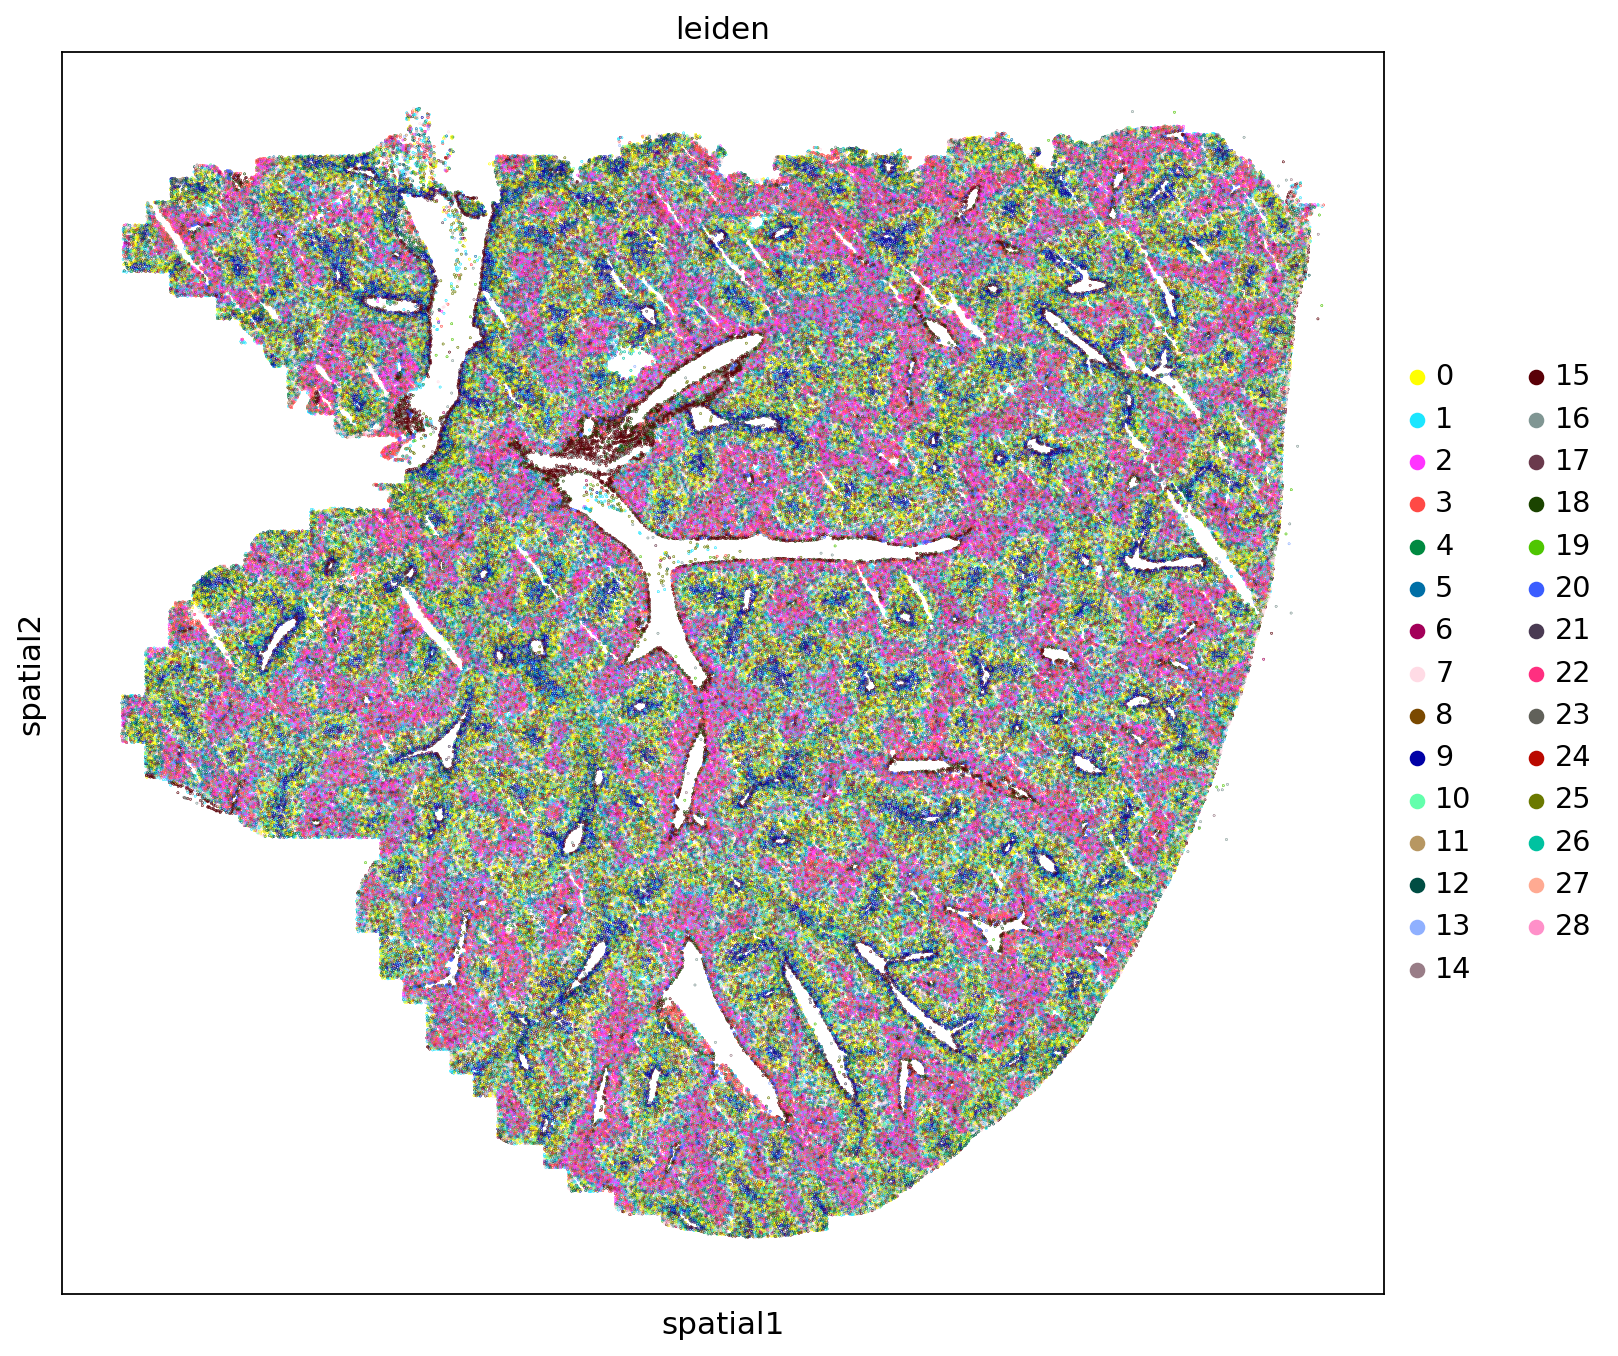

In [13]:
sq.pl.spatial_scatter(ad_viz, shape=None, color="leiden", size=0.1)

/home/icb/giovanni.palla/code/squidpy/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


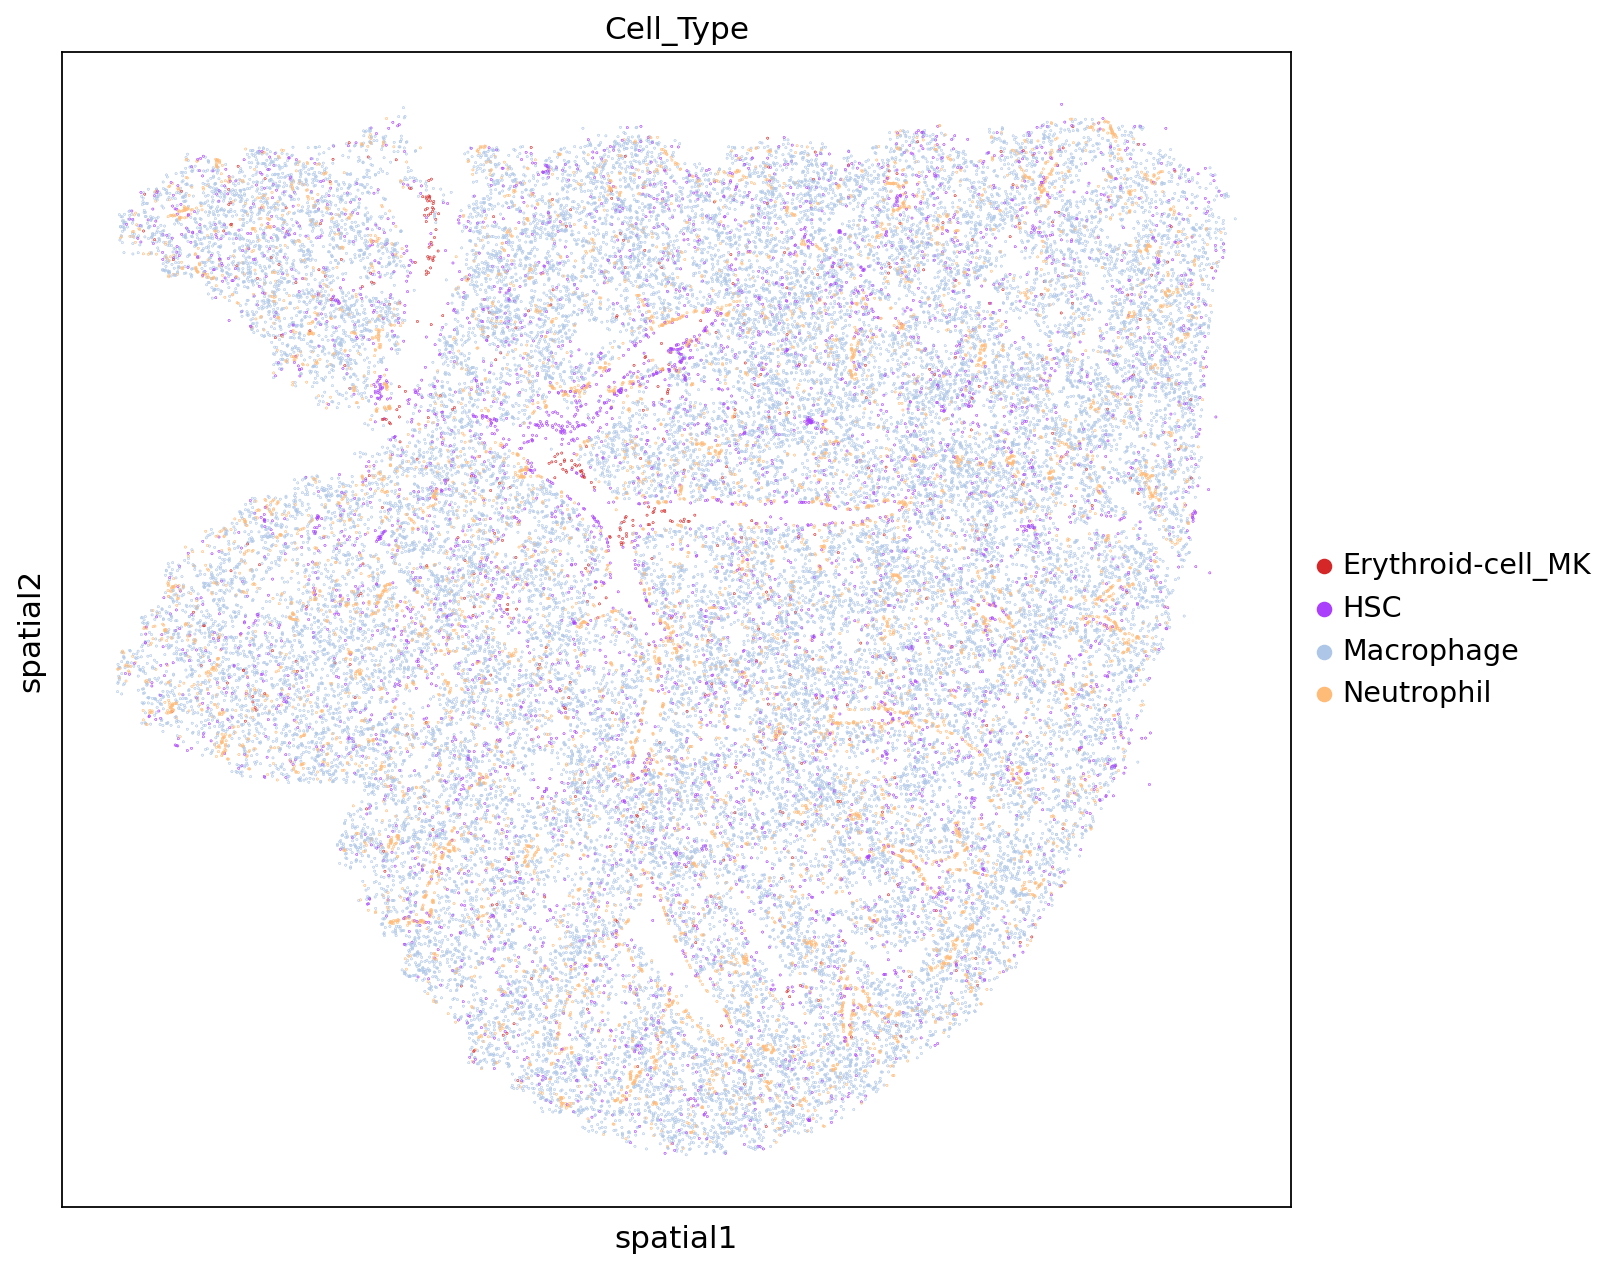

In [14]:
sq.pl.spatial_scatter(
    ad_viz,
    shape=None,
    color="Cell_Type",
    groups=[
        "Erythroid-cell_MK",
        "Erythroid-progenitor_Pre-B-cell",
        "Neutrophil",
        "Macrophage",
        "HSC",
    ],
    size=0.1,
)

In [15]:
path = pathlib.Path("/lustre/groups/ml01/workspace/moscot_paper/mapping")
ad_viz.write(path / "adata_result.h5ad")